# Construct the convex hull diagram of the Gibbs free energy of formation
Include the search results from the known phases and the search phases

In [1]:
%aiida
from aiida.orm import StructureData, SinglefileData
from ase.io import read
from aiida.engine import calcfunction, submit
from pathlib import Path
from tqdm.auto import tqdm
from tqdm.auto import tqdm

from toolchest.hull import *
import pandas as pd

from aiida_vasp.parsers.file_parsers.potcar import MultiPotcarIo
from pymatgen.entries.computed_entries import ComputedEntry


In [2]:
from collections import Counter
from pymatgen.analysis.phase_diagram import PDEntry, PhaseDiagram
from pymatgen import Composition
from toolchest.airssutils import PlotlyPDPlotter
from pymatgen.analysis.phase_diagram import PDPlotter

In [3]:
sgroup_run2 = Group.objects.get(label='li-fe-o-s/run2-airss-refine-structures')
sgroup_run1 = Group.objects.get(label='li-fe-o-s/run1-airss-refine-structures')
extra_group = Group.objects.get(label='li-fe-o-s/extra-search-structures')
kgroup = Group.objects.get(label='li-fe-o-s/mp-structures')

# Construct the dataframe

In [4]:
from toolchest.hull import get_relax_records

gcalc = Group.objects.get_or_create(label='li-fe-o-s/pbe-fe-u4-calcs')[0]

df = get_relax_records([gcalc], 520, group_with_structures=False)

df['entry'] = get_entry(df)
df['n_fe'] = df['pmg_struct'].apply(lambda x: x.composition['Fe'])
df['chemsys'] = df['pmg_struct'].apply(lambda x: x.composition.chemical_system)
df['natoms'] = df['structure'].apply(lambda x: len(x.sites))
df['e_pa'] = df['energy'] / df['natoms']

Entries: 500


In [8]:
import seaborn

In [9]:
def df2pd(df, corr=None):
    """
    Generate phase diagram from a DataFrame
    """
    pd_entries = []
    for idx, row in df.iterrows():
        if corr:
            correction  = corr.get_correction(row.entry)
            row.entry.correction = correction
        else:
            row.entry.correction = 0.0
        pd_entries.append(row.entry)

    #Apply gas correction
    gas_correct = 1.34 / 2 # Accounts the O-O overbinding energy
    for entry in pd_entries:
        if entry.composition.chemical_system == 'O':
            entry.correction = entry.composition['O'] * gas_correct

    return PhaseDiagram(pd_entries)

In [10]:
from toolchest.predictg import make_g_diagram

In [13]:
labels = ['label', 'formula', 'e_above_hull', 'e_pa', 'decomp', 'e_above_hull_known', 'decomp_known', 'relax_uuid', 'entry_energy', 'volume']
def get_computed_dasta_with_T(df, T):

    diagrams_h = {
        'search': df2pd(df),
        'known':  df2pd(df[~(df.label.str.contains('res') | (df.formula == 'Li2FeSO') | (df.label.str.contains('Enum')))], corr=None)
    }

    
    diagrams_g = {
        'search': make_g_diagram(diagrams_h['search'], T),
        'known': make_g_diagram(diagrams_h['known'], T)
    }
    
    # Add columns
    records = []
    index = []
    processed_entries = {entry.parameters['dataframe_idx']: entry for entry in diagrams_g['search'].all_entries}
    for idx, row in df.iterrows():
        entry = processed_entries[idx]
        decomp, dist_to_hull = diagrams_g['search'].get_decomp_and_e_above_hull(entry)
        decomp_knwon, dist_to_hull_known = diagrams_g['known'].get_decomp_and_e_above_hull(entry, allow_negative=True)
        records.append({
            'e_above_hull': dist_to_hull,
            'decomp': "+".join([c.composition.reduced_formula for c in decomp]),
            'decomp_entry': decomp,
            'decomp_known': "+".join([c.composition.reduced_formula for c in decomp_knwon]),
            'e_above_hull_known': dist_to_hull_known,
            'entry_energy': entry.energy_per_atom,
        })
        index.append(idx)
    pd_entries = pd.DataFrame(records, index=index)

    # Assign data to the DataFrame
    df_with_pd = pd.concat([df, pd_entries], axis=1).sort_values('e_pa')
    # Construct the series of G entries
    gentries = diagrams_g['search'].all_entries
    gentry_idx = [entry.parameters['dataframe_idx'] for entry in gentries]
    # Update the entries of Gibbs formation energy
    df_with_pd['gentry'] = pd.Series(gentries, index=gentry_idx)
    
    # Remove duplicates - some material has been computed multiple times - we simply take the first entry (lowest energy)
    mask = df_with_pd.duplicated('structure_uuid', keep='first')
    unique = df_with_pd[~mask]

    # Select the lowest energy structure of each composition
    tmp = unique.groupby('formula')['e_above_hull'].idxmin()
    lowest = unique.loc[tmp]
    # Filtered version with only the searched structures
    search_lowest = lowest[lowest.label.str.contains("res") | lowest.label.str.contains("Enum")]

    # Subset for showing
    to_show = search_lowest[search_lowest.e_above_hull < 0.500].sort_values('e_above_hull')
    return unique, lowest, to_show

In [14]:
# Here one should be very careful as the full set of structures may involve those very large volume
# Such candidates may not be physically reasonable, but if we compute the Gibbs free energym, they will be favoured at high temperature
# Solultion - use only those that are stable at 300 K for further calculation

temperatures = list(range(300, 1300, 100))
unique, lowest, to_show = get_computed_dasta_with_T(df, 300)
selected = df[df.label.apply(lambda x: x in lowest.label.values)]
all_data = {T:  get_computed_dasta_with_T(selected, T) for T in temperatures}


In [15]:
to_shows = []
for key, value in all_data.items():
    value[2]['temperature'] = key
    to_shows.append(value[2].set_index(['temperature', 'formula'], drop=False))
all_to_show = pd.concat(to_shows, axis=0)
all_to_show = all_to_show.swaplevel()

In [16]:
data_at_300 = all_to_show[all_to_show.index.get_level_values(1) == 300]
selected_formulas = data_at_300[data_at_300.e_above_hull < 0.150].formula.unique()
mask = np.in1d(all_to_show.index.get_level_values(0), selected_formulas)
all_to_show = all_to_show[mask]

In [17]:
e_above_hull = all_to_show[labels].unstack()['e_above_hull'].sort_values(300)
e_above_hull_known = all_to_show[labels].unstack()['e_above_hull_known'].sort_values(300)

entry_energy = all_to_show[labels].unstack()['entry_energy'].loc[e_above_hull.index]

d_entry_energy = entry_energy.subtract(entry_energy.loc[:, 300], axis='index')

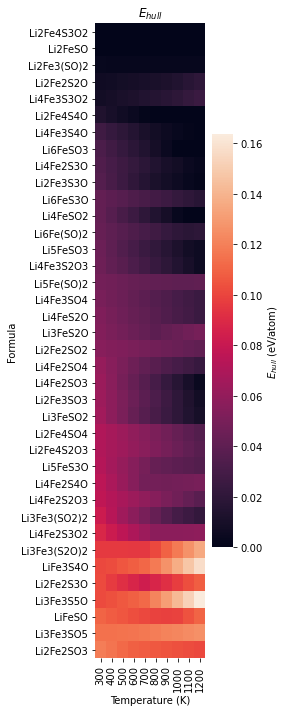

In [18]:
plt.figure(figsize=(4,10))
seaborn.heatmap(e_above_hull, cbar_kws={'label': r'$E_{hull}$ (eV/atom)'})
plt.title(r'$E_{hull}$')
plt.xlabel('Temperature (K)')
plt.ylabel('Formula')
plt.tight_layout()
plt.savefig('../../Li-Fe-S-O-paper/Figures/sisso-e_above_hull.svg')

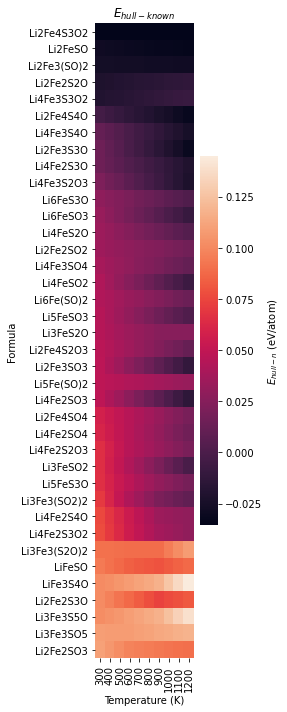

In [19]:
plt.figure(figsize=(4,10))
seaborn.heatmap(e_above_hull_known,cbar_kws={'label': r'$E_{hull-n}$ (eV/atom)'})
plt.title(r'$E_{hull-known}$')
plt.xlabel('Temperature (K)')
plt.ylabel('Formula')
plt.tight_layout()
plt.savefig('../../Li-Fe-S-O-paper/Figures/sisso-e_above_hull_known.svg')

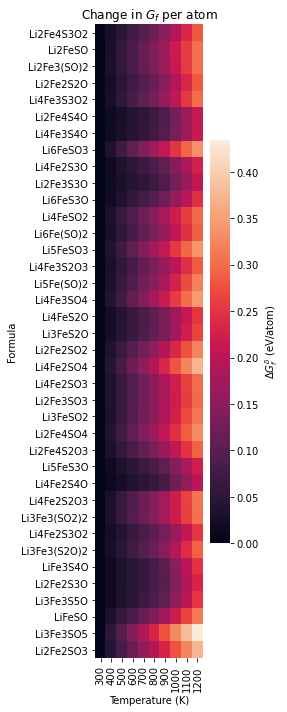

In [20]:
plt.figure(figsize=(4,10))
seaborn.heatmap(d_entry_energy, cbar_kws={'label': r'$\Delta G_f^{\delta}$ (eV/atom)'})
plt.title(r'Change in $G_f$ per atom')
plt.xlabel('Temperature (K)')
plt.ylabel('Formula')
plt.tight_layout()
plt.savefig('../../Li-Fe-S-O-paper/Figures/sisso-g-delta.svg')